#### iris 데이터셋 활용 꽃잎 너비 예측 모델  --- 선형회귀, 신경망 아님
- 데이터셋 : iris.csv에서 3개 Feature  사용
- 구현 프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비

In [1]:
# 모듈 로딩 
import torch                        # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn               # 인공신경망 관련 모듈
import torch.nn.functional as F     # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer     # 최적화 기법 관련 모듈

import pandas as pd                 # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split

In [2]:
torch.manual_seed(1)

In [3]:
# 데이터 로딩 : CSV ==> DataFrame
DATA_FILE = '../data/iris.csv'

irisDF = pd. read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [17]:
# in_features : sepal.length sepal.width petal.length 3개
# out_features : petal.width 1개
model = nn.Linear(3,1)

nn_model = nn.Sequential(nn.Linear(3,10),
                         nn.ReLU(),
                         nn.Linear(10,50),
                         nn.ReLU(),
                         nn.Linear(50,1))

In [5]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}, {param}]\n')

[weight, Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119]], requires_grad=True)]

[bias, Parameter containing:
tensor([0.2710], requires_grad=True)]



[3] 최적화 인스턴스 준비

In [6]:
# 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim = optimizer.Adam(model.parameters(), lr=0.1)

[4] 학습 ==> 개발자가 구현

-[4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행 하거나 또는 학습 전 진행

In [7]:
featureTS = torch.from_numpy(irisDF[irisDF.columns[:-1]].values).float()
featureTS.shape, featureTS.ndim

(torch.Size([150, 3]), 2)

In [8]:
targetTS = torch.from_numpy(irisDF[['petal.width']].values).float()
targetTS.shape, targetTS.ndim # 차원 맞춰서

(torch.Size([150, 1]), 2)

In [9]:
# Train & test
X_train, X_test, y_train, y_test = train_test_split(featureTS,
                                                    targetTS,
                                                    test_size=0.2)

# Train & val
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.2)

print(f'[feature] Train{X_train.shape}, Test{X_test.shape}, Cal{X_val.shape}')
print(f'[target] Train{y_train.shape}, Test{y_test.shape}, Cal{y_val.shape}')

[feature] Traintorch.Size([96, 3]), Testtorch.Size([30, 3]), Caltorch.Size([24, 3])
[target] Traintorch.Size([96, 1]), Testtorch.Size([30, 1]), Caltorch.Size([24, 1])


[4-2] 학습진행 : 진행전    
    - 학습횟수 결정 => 에포크 설정   
    - 학습결과 저장 => 손실저장 변수

In [10]:
EPOCH = 10 # 처음부터 끝까지

In [11]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행

# 모델 검증 및 테스트 
def testing(testTS,targetTS, kind="Val"):

    with torch.no_grad(): # 가중치 및 절편 업데이트 진행X

        # 1. 학습진행 - forward
        pre_y = model(testTS)
        print(f'{pre_y.shape}')

        # 2. 오차계산 - 손실함수
        loss = F.mse_loss(pre_y, targetTS) 

        # 4. 학습결과 출력 및 저장
        print(f'[ {kind} ] LOSS : {loss}')

    return loss

In [12]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):

    loss_history= [[],[]]

    for epoch in range(EPOCH):

        # 1. 학습진행 - forward
        pre_y = model(featureTS)
        print(f'{pre_y.shape}')

        # 2. 오차계산 - 손실함수 >>>> 평균이요???
        loss = F.mse_loss(pre_y, targetTS)  # loss >> tensor
        loss_history[0].append(loss.item())

        # 3. 최적화 - 가중치, 절편 업데이트 backward
        adam_optim.zero_grad() # 지금 이것들도 다 tensor
        loss.backward()
        adam_optim.step()

        # 3-1 검증 - 모델이 제대로 만들어지는지 검사용
        val_loss = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())

        # 4. 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS : {loss}')

    return loss_history

In [13]:
# 모델 학습 진행
loss = training(X_train, y_train, X_val, y_val)

torch.Size([96, 1])
torch.Size([24, 1])
[ Val ] LOSS : 0.9332978129386902
[0/10] LOSS : 0.6525238156318665
torch.Size([96, 1])
torch.Size([24, 1])
[ Val ] LOSS : 0.3742549419403076
[1/10] LOSS : 1.3216451406478882
torch.Size([96, 1])
torch.Size([24, 1])
[ Val ] LOSS : 0.5057819485664368
[2/10] LOSS : 0.5838128328323364
torch.Size([96, 1])
torch.Size([24, 1])
[ Val ] LOSS : 0.9447771906852722
[3/10] LOSS : 0.43377330899238586
torch.Size([96, 1])
torch.Size([24, 1])
[ Val ] LOSS : 0.7701179385185242
[4/10] LOSS : 0.7026843428611755
torch.Size([96, 1])
torch.Size([24, 1])
[ Val ] LOSS : 0.33962157368659973
[5/10] LOSS : 0.5675002336502075
torch.Size([96, 1])
torch.Size([24, 1])
[ Val ] LOSS : 0.15530741214752197
[6/10] LOSS : 0.27823635935783386
torch.Size([96, 1])
torch.Size([24, 1])
[ Val ] LOSS : 0.21541394293308258
[7/10] LOSS : 0.22642630338668823
torch.Size([96, 1])
torch.Size([24, 1])
[ Val ] LOSS : 0.22375917434692383
[8/10] LOSS : 0.35234615206718445
torch.Size([96, 1])
torch.Siz

In [14]:
loss

[[0.6525238156318665,
  1.3216451406478882,
  0.5838128328323364,
  0.43377330899238586,
  0.7026843428611755,
  0.5675002336502075,
  0.27823635935783386,
  0.22642630338668823,
  0.35234615206718445,
  0.3594088852405548],
 [0.9332978129386902,
  0.3742549419403076,
  0.5057819485664368,
  0.9447771906852722,
  0.7701179385185242,
  0.33962157368659973,
  0.15530741214752197,
  0.21541394293308258,
  0.22375917434692383,
  0.12846402823925018]]

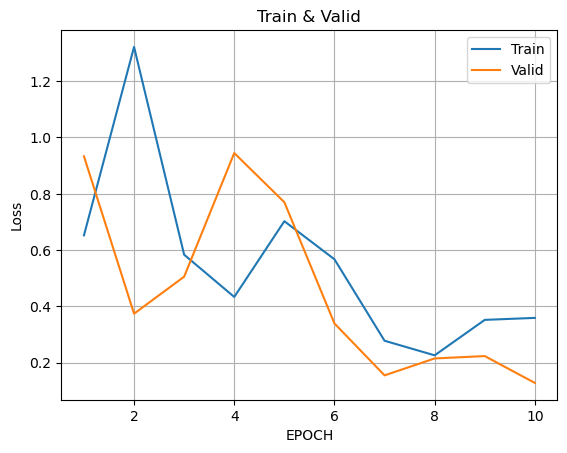

In [15]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt


plt.plot(range(1,11), loss[0], label='Train')
plt.plot(range(1,11), loss[1], label='Valid')
plt.title('Train & Valid')
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()